# ML Adaptive Beamformer for ULA



## Setup

First, import necessary packages and libraries:

In [1]:
import os
import pathlib

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.constants

import tensorflow as tf

### Parameters & Constants

Set ULA parameters and system constants:

In [2]:
N       = 16    # number of elements in ULA
fc      = 300e6 # carrier frequency
fs      = 1e9   # sampling frequency
theta   = 0     # wave Angle of Arrival (AoA) in degrees
SNR     = 1     # element SNR (linear units)
noiseP  = 1     # noise power (linear units)
spacing = 0.5   # d/wavelength element spacing (0.5 = half-wavelength spacing)

wavelength = fc/scipy.constants.c
# generate array of antenna element positions
antPos = np.linspace(0,N-1,N)*wavelength*spacing

Create spatial response vector at each ULA element that follows
$$ e^{\frac{j2\pi}{\lambda} \sin{\theta} } $$

In [3]:
cmplx_pos = (1j*2*scipy.constants.pi/wavelength)*antPos
d = np.exp(cmplx_pos*np.sin(np.deg2rad(theta)))

Compute hypothesis of steering vectors in sine space for quiescent beamforming weights. Plot the weight response over sine space by testing weight magnitude at each look direction in vector `u`, from $-90^{\circ}$ to $90^{\circ}$

In [4]:
numHyp = 400
u = np.linspace(-1,1,numHyp)
# create matched filter (beam weights) for quiescent case (no interference)
cmplx_pos.shape = (1,N) # force transpose from row to column vector
wq = np.exp(np.outer(np.array(cmplx_pos), u))
# unit normalize filter weights
mag = wq * wq.conj()
wq = wq / mag.sum(axis=0) # sum over columns (each channel, per hypothesis)

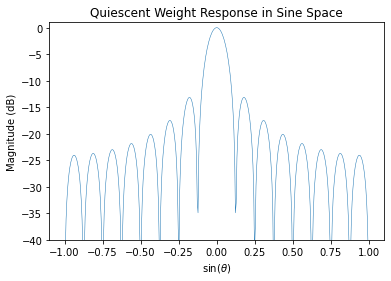

In [5]:
yq = np.inner(wq.conj().T, d)
fig, ax = plt.subplots()
ax.plot(u, 20*np.log10(np.abs(yq)), linewidth=0.5)
ax.set(xlabel=r'$\sin(\theta)$',
       ylabel='Magnitude (dB)',
       title='Quiescent Weight Response in Sine Space')
ax.set_ylim([-40, 1]) # set sensible magnitude limits since edges near 0 gain
plt.show()

[Windowing](https://en.wikipedia.org/wiki/Window_function) can be applied to weights as well to adjust sidelobes, such as applying a Hamming window which is weighted by:
$$ w(n) = 0.54 - 0.46\cos(\frac{2\pi n}{M - 1}) \quad 0 \leq n \leq M - 1 $$

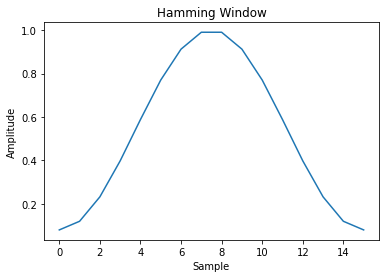

In [6]:
window = np.hamming(N)
plt.plot(window)
plt.title("Hamming Window")
plt.ylabel("Amplitude")
plt.xlabel("Sample")
plt.show()

As expected, the great reduction in sidelobes causes an increase in mainlobe width compared to non-windowed weights. Windowing is always a balance between sidelobe performance and mainlobe width.

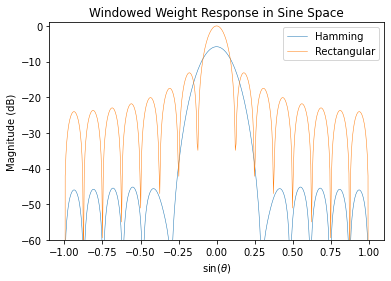

In [7]:
w_ham = window * d
y_ham = np.inner(wq.conj().T, w_ham)
fig, ax = plt.subplots()
ax.plot(u, 20*np.log10(np.abs(y_ham)), u, 20*np.log10(np.abs(yq)), linewidth=0.5)
ax.set(xlabel=r'$\sin(\theta)$',
       ylabel='Magnitude (dB)',
       title='Windowed Weight Response in Sine Space')
ax.set_ylim([-60, 1]) # set sensible magnitude limits since edges near 0 gain
ax.legend(['Hamming', 'Rectangular'])
plt.show()

#### Notes/`TODO`:
- Decided on CNN model for adaptation to ABF use case:
  + I still want to build the covariance sample/estimation matrix on front end before the CNN;(its easy (HDL and implementation is fairly easy and not very resource heavey), and input layer is then pretty simple. For instance, instead of having to "window" a certain amount of data (say 1000 samples) for each channel as the input layer (which could be very resource heavy) an 8 channel system can have a 2D 8x8 input layer (8 channel rows x 8 covariance columns x 2 samples per I/Q) which should lead to much lighter overall resource usage (and easier training)
    * The above input layer is not fully complete though, I also need to have some way to input the desired steering direction, perhaps as just a separate "channel"? (e.g. a 9x8 input layer for the 8 true channel case, where the extra row is the set of steering weights `d`, similar to how this vector is given in traditional QRD processes?). This should be OK since a CNN has no concept of what's what, the "magic" will be in training it anyways...
    * I do also want to model some scenarios where I _don't_ have the covariance matrix on the front end, just to see how much larger the overall CNN becomes with the much wider input layer. Through training, the CNN might "come up" with a more efficient/better model anyways...
    * Two other interesting input preprocessing should also be considered:
      - Using [STFT](https://en.wikipedia.org/wiki/Short-time_Fourier_transform) (or overlapped/RTSA to get both time & frequency resolution) BUT instead of taking it across the temporal domain (e.g. across the time domain of each channel's samples like traditional FFT processing), we take it across the spatial dimension (e.g. across all channels, btw could process an 8-channel system with 8-pt FFT per sample, or larger FFT like 64-pt+ by stacking inputs?). We can make a good comparison to STFT used in audio/RF classification tasks (like TF's example and RadioML)
      - Investigate performance with input from [CWT, WVD or other time-frequency transform](https://www.mathworks.com/help/signal/ug/time-frequency-gallery.html#responsive_offcanvas)?
      - Investigate any other [Lossy Compression](https://en.wikipedia.org/wiki/Lossy_compression) preprocessing methods, like [DCT](https://en.wikipedia.org/wiki/Discrete_cosine_transform) or [DWT](https://en.wikipedia.org/wiki/Discrete_wavelet_transform), which can create compressed 2D input layers?
  + The output layer should be 2D for complex weights (N channels x 2 per I/Q weight), since the goal is to have a CNN which can directly create weights for beamforming "weight and sum"/MAC application in PL logic.
  + The value function for training is based on computing the Signal to Interference + Noise (SINR) calculation for a given test's output weights and training sample set; the greater the SINR, the greater the "accuracy". This may lead to a more compute intensive training process (as opposed to simple/traditional classification examples which can build confusion matrices/binary success models), but SINR calculation is not too terrible
    * Reinforcement learning vs supervised (since not labeled data set)?
  + The generated test data sets for each training epoch can be built on-the-fly since, with given mathematical RF signal models, we can create relatively realistic test data. Different parameters should vary to best train the CNN (as well as buck "overfitting" to a specific dataset/test) like:
    * Desired & interference signal modulation and bandwidths (e.x. simple AM/tone, QPSK, QAM, OFDM, LFM/chirp, etc.)
    * Noise, including noise type (e.g. more than just gaussian white noise), also varying if noise is phase shifted along with interference signal
    * Number of interference sources (up to num_channels - 1 theoretical nulling limits)
    * Desired & interference signal directions
    * Desired & interference signal SNRs
      + In Tim O'Shea's RadioML research, he built an interesting graph which was able to show model accuracy vs input SNR, where expectedly, very low SNR (or signals below noise) led to less probability of modulation classification (different application than us btw, though the RadioML dataset could be another interesting test source)
  + At the end of creating floating-point model in TensorFlow, the extra quantization tools (which are used for embedded targets like TF Lite) should output a fixed point model for comparison as well (since this would be easiest/most resource optimized for FPGA logic implementation)
    * Full FP32 model is still useful though as we could use HLS tools like Xilinx Vitis AI and hls4ml to create PL blocks for resource/performance comparison.